# 6. Maze Deep Q-learning.ipynb

### About this notebook

This notebook was used in the 50.039 Deep Learning course at the Singapore University of Technology and Design.

**Author:** Matthieu DE MARI (matthieu_demari@sutd.edu.sg)

**Version:** 1.0 (04/02/2025)

**Requirements:**
- Python 3 (tested on v3.13.1)
- Matplotlib (tested on v3.10.0)
- Numpy (tested on v2.2.1)
- Torch (tested on v2.7.0+cu124)
- collections, enum (Standard libraries for Python)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from maze import *

In [2]:
# Seeding for reproducibility
torch.manual_seed(37)
np.random.seed(21)
random.seed(12)

### Creating the Maze environment

As in Notebook 4, we will reuse our Maze class and create a Maze environment with a given layout.

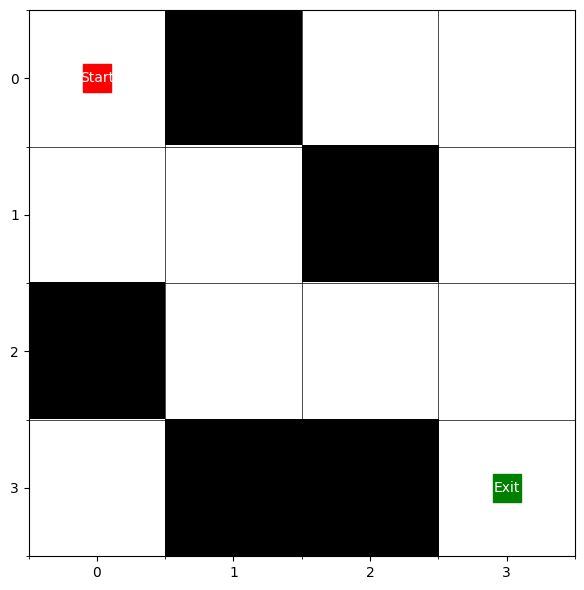

In [3]:
# Define a simple maze layout
# 0 = free, 1 = wall
maze_layout = np.array([[0, 1, 0, 0],
                        [0, 0, 1, 0],
                        [1, 0, 0, 0],
                        [0, 1, 1, 0]])

# Initialize the Maze environment
maze = Maze(maze = maze_layout, start_cell = (0, 0), exit_cell = (3, 3))

# Reset the maze
initial_state = maze.reset(start_cell = (0, 0))

# Display the maze
maze.draw_full_maze()

### Define the Deep-Q-Learning agent

Next, we will define our Q-Network, which will serve as the function approximator for Q-values in our Reinforcement Learning (RL) agent. This neural network will be used to estimate the expected rewards for different actions in a given state. The QNetwork class has the typical attributes, init and forward methods you expect from a Neural Network.

The QNetwork is used by the agent to predict the best action in any given state. Instead of maintaining a traditional Q-table, this network generalizes learning across different states using deep learning.

This neural network is critical for deep Q-learning, as it enables the agent to navigate the maze effectively. Next, we will integrate this network into our Deep Q-Learning agent, where it will be trained using Reinforcement Learning principles.

In [4]:
# Neural network for approximating Q-values
class QNetwork(nn.Module):
    """
    Out Q-Neural Network for predictions
    """
    def __init__(self, input_size, hidden_size, output_size):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        return x

Next, we define our Deep Q-Learning agent, which interacts with the environment and learns an optimal policy using a neural network. Our DQLAgent class represents an AI agent that:
- Explores and exploits the environment.
- Uses a deep neural network (Q-Network) to approximate Q-values.
- Trains using Deep Q-Learning (DQL) to learn the optimal Q-values and use them to find the optimal moves.
- Improves over time by balancing exploration and exploitation, with exploration rate decay.

Our agent class has the following attributes:
- environment: The Maze environment the agent interacts with.
- q_network: The neural network that approximates Q-values, which we defined earlier
- optimizer: A simple Adam optimizer, used to update the neural network.
- criterion: Our loss function (MSELoss) to compute prediction errors.

Our agent has the following methods
- init(self, maze, learning_rate, hidden_size): Initializes the agent with a given learning_rate, the hidden size to be userd in the Q-network that predicts Q-values for state-action pairs.
- q(self, state): Returns the Q-values for all possible actions in a given state. Uses the trained Q-network without modifying it.
- predict(self, state): Uses the Q-network to predict the best action (highest Q-value) in a given state.
- train(self, discount, exploration_rate, exploration_decay, episodes, stop_at_convergence): The core training function for Deep Q-Learning. The agent plays the game multiple times (for a given number of episodes), learning optimal moves over time.

In the last method, the training process consists of looping through multiple episodes, and on each episode, the game unfolds by following these steps:
- First, we start from a random valid position in the maze (not necessarily the start)
- In each state, we select actions using ε-greedy strategy. If an exploration move is selected, use a random action. If an exploitation move is selected, use the predict method to choose the best move to use given our current understanding of the game.
- After a move is taken in a given state, we update Q-values using Bellman’s equation.
- We then train the neural network using gradient descent to match the new Q-values.

While looping through multiple episodes, we will track cumulative rewards, track our win rate over time, and perform a decay exploration to shift from exploring to exploiting. If the agent successfully reaches the goal from all states, training stops early.

Using this RL framework, our Q-learning model will eventually learn the true action-value function (Q(s, a)) that estimates future rewards and use that to decide on the optimal action to use in any state.

In [5]:
class DQLAgent:
    """
    Deep Q-Learning agent using a neural network.
    """
    def __init__(self, maze, learning_rate = 0.01, hidden_size = 64):
        self.environment = maze
        self.name = "DQLModel"
        # State is represented by current position (x, y)
        input_size = 2
        # Neural network solves a classification problem, returning Q-value of each action based on state
        output_size = len(self.environment.actions)
        # Create neural network
        self.q_network = QNetwork(input_size, hidden_size, output_size)
        # Basic Adam optimizer and MSE as loss
        self.optimizer = optim.Adam(self.q_network.parameters(), lr = learning_rate)
        self.criterion = nn.MSELoss()

    def q(self, state):
        """
        Get Q-values for all actions for a certain state.
        """
        state = torch.tensor(state.flatten(), dtype = torch.float32)
        with torch.no_grad():
            return self.q_network(state).numpy()

    def predict(self, state):
        """
        Policy: choose the action with the highest Q-value.
        """
        state = torch.tensor(state.flatten(), dtype = torch.float32)
        with torch.no_grad():
            q_values = self.q_network(state)
            return torch.argmax(q_values).item()
    
    def train(self, discount = 0.90, exploration_rate = 1, exploration_decay = 0.995, episodes = 200, stop_at_convergence = True):
        """
        Train the model using Deep Q-Learning.
        """
        # Parameters for tracking training
        check_convergence_every = 5
        cumulative_reward = 0
        cumulative_reward_history = []
        win_history = []
        start_list = list()
        # Play the game for the specified number of times
        for episode in range(1, episodes + 1):
            # Start from a randomly decided cell
            if not start_list:
                start_list = self.environment.empty.copy()
            start_cell = random.choice(start_list)
            start_list.remove(start_cell)
            state = self.environment.reset(start_cell)
            state = torch.tensor(state.flatten(), dtype = torch.float32)
            # Display
            if episode % 100 == 1 or episode == episodes:
                print(f"Episode: {episode} - Exploration rate: {exploration_rate}")

            while True:
                # Epsilon-greedy action selection
                if np.random.random() < exploration_rate:
                    # Exploration move, randomly deciding
                    action = random.choice(self.environment.actions)
                else:
                    # Exploitation move, using the Neural Network to decide on the best move
                    with torch.no_grad():
                        q_values = self.q_network(state)
                        action = torch.argmax(q_values).item()

                # Take action and observe the result, update reward
                next_state, reward, status = self.environment.step(action)
                next_state = torch.tensor(next_state.flatten(), dtype = torch.float32)
                cumulative_reward += reward

                # Compute target Q-value
                with torch.no_grad():
                    max_next_q = torch.max(self.q_network(next_state)).item()
                    target = reward + discount*max_next_q if status == Status.PLAYING else reward

                # Update Q-value using the loss
                q_values = self.q_network(state)
                target_q_values = q_values.clone()
                target_q_values[action] = target
                loss = self.criterion(q_values, target_q_values)

                # Backpropagation
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                # Stop playing current episode if game has ended
                if status in (Status.WIN, Status.LOSE):
                    break
                else:
                    state = next_state

            # Record cumulative rewards
            cumulative_reward_history.append(cumulative_reward)

            # Check convergence and stop early if agent has learnt everything already
            if episode % check_convergence_every == 0:
                w_all, win_rate = self.environment.check_win_all(self)
                win_history.append((episode, win_rate))
                if w_all is True and stop_at_convergence is True:
                    print("Won from all start cells. Stopped learning")
                    break

            # Decay exploration rate for exploration-exploitation trade-off
            exploration_rate *= exploration_decay

        # Upon ending return all infos
        return cumulative_reward_history, win_history

### Training the agent

Below, we will use the code above to create a Deep Q-learning agent and train it by playing the game repeatedly. We will seed the code to ensure reproducibility.

In [6]:
# Create agent model
model = DQLAgent(maze, learning_rate = 0.01, hidden_size = 64)

We then use our train() method to run 2,000 training episodes, where the agent plays the game repeatedly to eventually learn the best strategy.
A friendly reminder on the inputs of this train() method and their meaning, below:
- discount = 0.95: The discount factor (γ), controlling how much future rewards influence current decisions. A higher value (closer to 1) makes the agent focus more on long-term rewards.
- exploration_rate = 1.0: The initial probability of taking random actions instead of choosing the best-known action. Here, 1.0 means full exploration at the start.
- exploration_decay = 0.995: The rate at which exploration decreases over time. This ensures that the agent starts by exploring but gradually shifts to exploitation (following learned policies). You can see the evolution of the exploration rate, progressively shifting from 1 to 0 over the different episodes.
- episodes = 2000: The number of games (episodes) the agent will play to learn an optimal policy.
- stop_at_convergence = True: If the agent consistently wins from all possible states, training stops early to save computation time.

In [7]:
# Train agent
h, w = model.train(discount = 0.95, exploration_rate = 1.0, exploration_decay = 0.995, episodes = 2000, stop_at_convergence = True)

Episode: 1 - Exploration rate: 1.0
Episode: 101 - Exploration rate: 0.6057704364907278
Episode: 201 - Exploration rate: 0.3669578217261671
Episode: 301 - Exploration rate: 0.22229219984074702
Episode: 401 - Exploration rate: 0.1346580429260134
Episode: 501 - Exploration rate: 0.08157186144027828
Episode: 601 - Exploration rate: 0.0494138221100385
Episode: 701 - Exploration rate: 0.029933432588273214
Episode: 801 - Exploration rate: 0.018132788524664028
Episode: 901 - Exploration rate: 0.01098430721937979
Episode: 1001 - Exploration rate: 0.006653968578831948
Episode: 1101 - Exploration rate: 0.004030777450394616
Episode: 1201 - Exploration rate: 0.002441725815522529
Episode: 1301 - Exploration rate: 0.0014791253130597608
Episode: 1401 - Exploration rate: 0.0008960103865166974
Episode: 1501 - Exploration rate: 0.0005427766029404454
Episode: 1601 - Exploration rate: 0.0003287980196801882
Episode: 1701 - Exploration rate: 0.0001991761198989547
Episode: 1801 - Exploration rate: 0.000120655

As shown in the curves below, the agent improves significantly over time, reaching a high win rate. The cumulative reward also increases steadily, indicating efficient pathfinding behavior. There are still some fluctuations in win rate, which suggest that the agent is still learning a few things about the game and has not yet achieved a perfect understanding of the game, but overall, it seems to be improving.

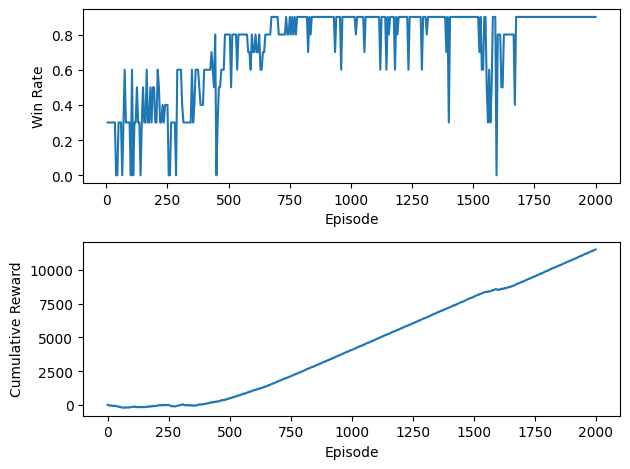

In [8]:
# Display training curves
fig, (ax1, ax2) = plt.subplots(2, 1, tight_layout = True)
ax1.plot(*zip(*w))
ax1.set_xlabel("Episode")
ax1.set_ylabel("Win Rate")
ax2.plot(h)
ax2.set_xlabel("Episode")
ax2.set_ylabel("Cumulative Reward")
plt.show()

### Testing the agent predictions capabilities

Below, we test our agent by checking which actions it produces in several cells of the maze. Since our predictions match expectations, it means the agent has learned the correct optimal path for our maze (at least for these cells!).

In [9]:
# Test predictions
# Expected: Best move for cell (0, 0) is down, which is index 3
pos1 = np.array((0, 0))
print(model.predict(pos1))
# Expected: Best move for cell (1, 2) is right, which is index 1
pos2 = np.array((1, 2))
print(model.predict(pos2))
# Expected: Best move for cell (3, 2) is down, which is index 3
pos3 = np.array((3, 2))
print(model.predict(pos3))

3
1
3


Finally, we can, visualize the entire maze and the best move to use in each walkable cell using our helper method below.

When starting in cell (0, 0), the agent is clearly able to identify the shortest path to exit the maze without hitting any walls!

There are however cells that are still problematic... For instance cell (0, 3) suggests to go left, which is wrong, but not the end of the world given that this cell is impossible to reach from (0, 0).

While this suggests that the Deep-Q-Learning agent has yet more to learn about the maze and the best moves to use, this agent is, however, capable of finding the shortest path from (0, 0) to (3, 3)!

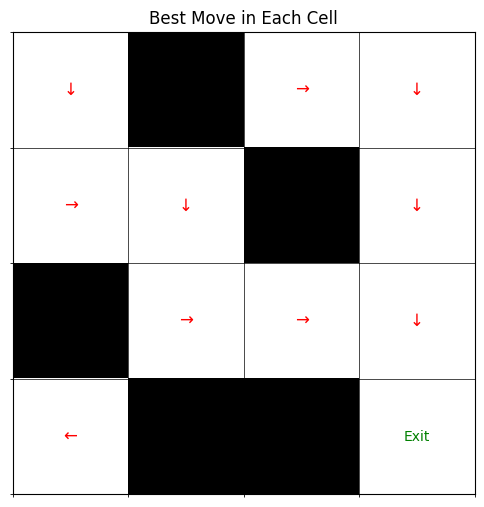

In [10]:
# Visualize best moves in each cell after training
maze.visualize_best_moves(model)